# Animating Quantum Wave Packets

Here we define a 'Schrodinger' class in order to input different wavepackets and potential barriers and produce an animation through time.

We use the strang splitting method, also called the split operatot method, to evolve the wave packet. This is a numerical method to solve non linear partial differential equations such as the Schrödinger equation.

The Schrödinger equation is of the form $\hat{H}\psi(x,t) = i\hbar \frac{\partial}{\partial t}\psi(x,t)$ where the Hamiltonian $\hat{H}$ is the sum of the kinetic and potential operators $\hat{H} = \hat{T} + \hat{V}$. Then solving the Schrödinger equation involes solving an equation of the form $\psi(x,t) = e^{-\frac{i}{\hbar}\hat{H}t}\psi(x,0)$.
This is where the split operator method comes in time steps:

$\psi(x,t+dt) = e^{-\frac{i}{\hbar}\hat{H}dt}\psi(x,t) = e^{-{\frac{i(\hat{T}+\hat{V})}{\hbar}dt}}\psi(x,t)\approx e^{-\frac{i\hat{V}}{2\hbar}dt}e^{-\frac{i\hat{T}}{\hbar}dt}e^{-{\frac{i\hat{V}}{2\hbar}dt}}\psi(x,t)$ which encompeses Strang splitting as we do a half step in potential, a full step in kinetic and a half step again in potential. We also have to put Fourier and inverse Fourier transforms in between these steps as we switch from position to momentum space. The full method as we see in the code is:

$\psi(x,t)$ half step in potential $\rightarrow e^{-\frac{i\hat{V}}{2\hbar}dt}\psi(x,t)$ Fourier transform and full step in position $\rightarrow e^{-\frac{i\hat{T}}{\hbar}dt}e^{-\frac{i\hat{V}}{2\hbar}dt}\psi(p,t)$ inverse Fourier transform and half step in potential $\rightarrow e^{-\frac{i\hat{V}}{2\hbar}dt}e^{-\frac{i\hat{T}}{\hbar}dt}e^{-\frac{i\hat{V}}{2\hbar}dt}\psi(x,t) = \psi(x,t+dt)$.

This is then done for every time step dt.

There are some numerical considerations with the Fourier transform, as we use the dicrete fast Fourier transform (FFT) and inverse fast Fourier transform (iFFT) in the code. This means we have to what we call 'discretise' the wave packets before and 'un-discretise' them after by multiplying them by some constants, determed elsewhere in my project.


In [147]:
#code modified from Jake Vanderplas
#email: vanderplas@astro.washington.edu
#github: http://jakevdp.github.com
#modifications made by Jess Winerborne
#github: https://github.com/JessWinterborne
#license: BSD
#free use and modification is allowed if the above information is retained


import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.fftpack import fft,ifft
from matplotlib import rc
rc('animation', html='jshtml')

class Schrodinger:
    def __init__(self, x, psi_x0, V_x, k0 = None, hbar = 1, m=1, t0=0.0):
        #x = xaxis array of length N giving position
        #V_x = yaxis array of length N giving potential
        #psi_x0 = array of length N giving intial wave function at t0
        #k0 gives the minimumum value of the momentum over hbar 
        #there are some constraints on this due to the FFT: k0<k<2pi/dx where dx = x[1]-x[0]
        #default hbar = 1 and mass = 1 and initial time = 0
        self.x, psi_x0, self.V_x = map(np.asarray, (x, psi_x0, V_x))
        N = self.x.size
        assert self.x.shape == (N,)
        assert psi_x0.shape == (N,)
        assert self.V_x.shape == (N,)
        self.hbar = hbar
        self.m = m
        self.t = t0
        self.dt_ = None
        self.N = len(x)
        self.dx = self.x[1] - self.x[0] 
        #setting the pos steps (similar to doing dx = b-a/N as coordinates are evenly spaced)
        self.dk = 2 * np.pi / (self.N * self.dx) 
        #dk = 2pi/Ndx (do this so FFT looks like continuous fourier transform)
        #dk = 2pi/b-a
        
        if k0 == None:
            self.k0 = -0.5 * self.N * self.dk
        else:
            self.k0 = k0
        self.k = self.k0 + self.dk * np.arange(self.N) 
        # k = k0 + dk
        self.psi_x = psi_x0
        self.psi_x = psi_x0
        
        #variables which hold steps in evolution
        self.x_evolve_half = None
        self.x_evolve = None
        self.k_evolve = None
        
        #attributes used for dynamic plotting
        self.psi_x_line = None
        self.psi_k_line = None
        self.V_x_line = None
        
    def _set_psi_x(self, psi_x):
        #brings it back to the original continuous version of psi(x)
        self.psi_discrete_x = (psi_x * np.exp(-1j * self.k[0] * self.x) * self.dx / np.sqrt(2 * np.pi))
        
    def _get_psi_x(self):
        #gives the discrete vesion of psi needed for the FFT
        return(self.psi_discrete_x * np.exp(1j * self.k[0] * self.x) * np.sqrt(2 * np.pi) / self.dx)
        
#     def _set_psi_k(self, psi_k):
#         self.psi_mod_k = psi_k * np.exp(1j * self.x[0] * self.dk * np.arange(self.N))

#     def _get_psi_k(self):
#         return self.psi_mod_k * np.exp(-1j * self.x[0] * self.dk * np.arange(self.N))
# #can uncomment this stuff if we want to animate in momentum space too

    def _get_dt(self):
        return self.dt_

    def _set_dt(self, dt):
        #how we evolve psi - half steps in position space and full steps in momentum space
        #as we will see in the strang splitting method below
        if dt != self.dt_:
            self.dt_ = dt
            self.x_evolve_half = np.exp(-0.5 * 1j * self.V_x / self.hbar * dt ) 
            self.k_evolve = np.exp(-0.5 * 1j * self.hbar / self.m * (self.k * self.k) * dt)  
    
    psi_x = property(_get_psi_x, _set_psi_x)
#     psi_k = property(_get_psi_k, _set_psi_k)
    dt = property(_get_dt, _set_dt)
    #dont really understand property functions well
    #from what I understand, property assigns getter and setter functions to a variable
    
    def time_step(self, dt, Nsteps = 1):
        self.dt = dt
        
        #strang splitting:
        for i in range(Nsteps):
            #half step in position:
            self.psi_discrete_x *= self.x_evolve_half
            #FFT
            self.psi_discrete_k = fft(self.psi_discrete_x)
            #full step in momentum
            self.psi_discrete_k *= self.k_evolve
            #iFFT
            self.psi_discrete_x = ifft(self.psi_discrete_k)
            #half step in position
            self.psi_discrete_x *= self.x_evolve_half
        
        self.t += dt * Nsteps
        #t = t + Nsteps*dt
        
def gauss_x(x, a, x0, k0):
    #wave with width a, centred at x0 with momentum k0
    return((a * np.sqrt(np.pi)) ** (-0.5) * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))
    #this is just a standard gaussian function
    
def gauss_k(k,a,x0,k0):
    #analytical (?) fourier transform of the gaussian in x above
    return ((a / np.sqrt(np.pi))** 0.5 * np.exp(-0.5 * (a * (k - k0)) ** 2 - 1j * (k - k0) * x0))


Here we set some different variables: the potential barrier, the initial wavepacket including its initial centre and momentum etc. and we can change other variables incuding $\hbar$, time, and many more.

In [148]:
#variables we can change:

#specify range in x coordinates
N = 2 ** 11 #2048
dx = 0.1
#setting x grid
x = dx * (np.arange(N) - 0.5 * N)

#potential barriers
#e.g.
def theta(x):
    #returns 0 if x<=0 and 1 if x>0
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y[x > 0] = 1.0
    return y

def square_barrier(x, width, height):
    return height * (theta(x) - theta(x - width))

#e.g.
def gauss_barrier(x, a, x0):
    x = np.asarray(x)
    #return (np.e**((-x**2)/1))*0.5
    return (a * np.sqrt(np.pi))** (-0.5) * np.exp(-0.5 * ((x - x0)*1./a) ** 2)
#also could have + np.e**((-(x+75)**2)/1) + np.e**((-(x-75)**2)/1)

V_x = gauss_barrier(x, 3, 0)
#V_x = gauss_x(x, 3, 0, 0)
V0 = np.max(V_x)
#or could have 1.0


#potential 'walls' at either end
V_x[x < -98] = 1E6 
V_x[x > 98] = 1E6


#more variables:

dt = 0.01
N_steps = 50
t_max = 200 #can change tmax to run for longer / shorter times
frames = 230


#specify constants
hbar = 1.0  
m = 1.0 #mass    
p0 = np.sqrt(2 * m  * 1.25 * V0) #intial momentum
#p0 = 1.0
#print what this is roughly why have we chosen it to be related to V0?
#if potential barrier = 0 then this is affected
#try p0 = number
k0 = p0 / hbar #intial wave number
v0 = p0 / m #initial velocity since momentum = mass x velocity
d = 4.0 #will input as width of wavepacket
x0 = -20 #initial centre of wavepacket 

psi_x0 = gauss_x(x, d, x0, k0)

0.43366253529203874


Creating a function to automate saving the individual frames and the whole video animation 


In [153]:
def save_wave(xlim, ylim, S, frames, dt, N_steps, name, scaling, save = True):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111, xlim=xlim, ylim=ylim)
    #have subplot so we can add in a plot for the momentum if we wanted (see below)
    psi_x_line, = ax.plot([], [], c='r', label=r'$|\psi(q)|^2$')
    # psi_k_line, = ax2.plot([], [], c='r', label=r'$|\psi(k)|$')
    V_x_line, = ax.plot([], [], c='k', label=r'$V(q)$')
    title = ax.set_title('')
    ax.legend(prop = dict(size=12))
    ax.set_xlabel('$q$')
    ax.set_ylabel(r'$|\psi(q)|^2$')
    V_x_line.set_data(S.x, S.V_x)
    def init():
        psi_x_line.set_data([], [])
        V_x_line.set_data([], [])
        return (psi_x_line, V_x_line)
    if save == True:
        try:
            os.mkdir(os.path.join(os.getcwd(),'wave_frames'))
        except FileExistsError:
            print("Frames folder found, overwritting")
    def animate(i):
        psi_x_line.set_data(S.x, scaling*abs(S.psi_x)**2)
        #factor in front just scales the wave function up
        V_x_line.set_data(S.x, S.V_x)
        title.set_text('t=%.2f' %S.t)
        if save == True:
            plt.savefig('wave_frames/wave_frame=%2f.png'%i)
        S.time_step(dt, N_steps)
        return (psi_x_line, V_x_line)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=40, blit=True)
    if save == True:
        anim.save(name+'.mp4')
    else:
        return(anim)

Animating:

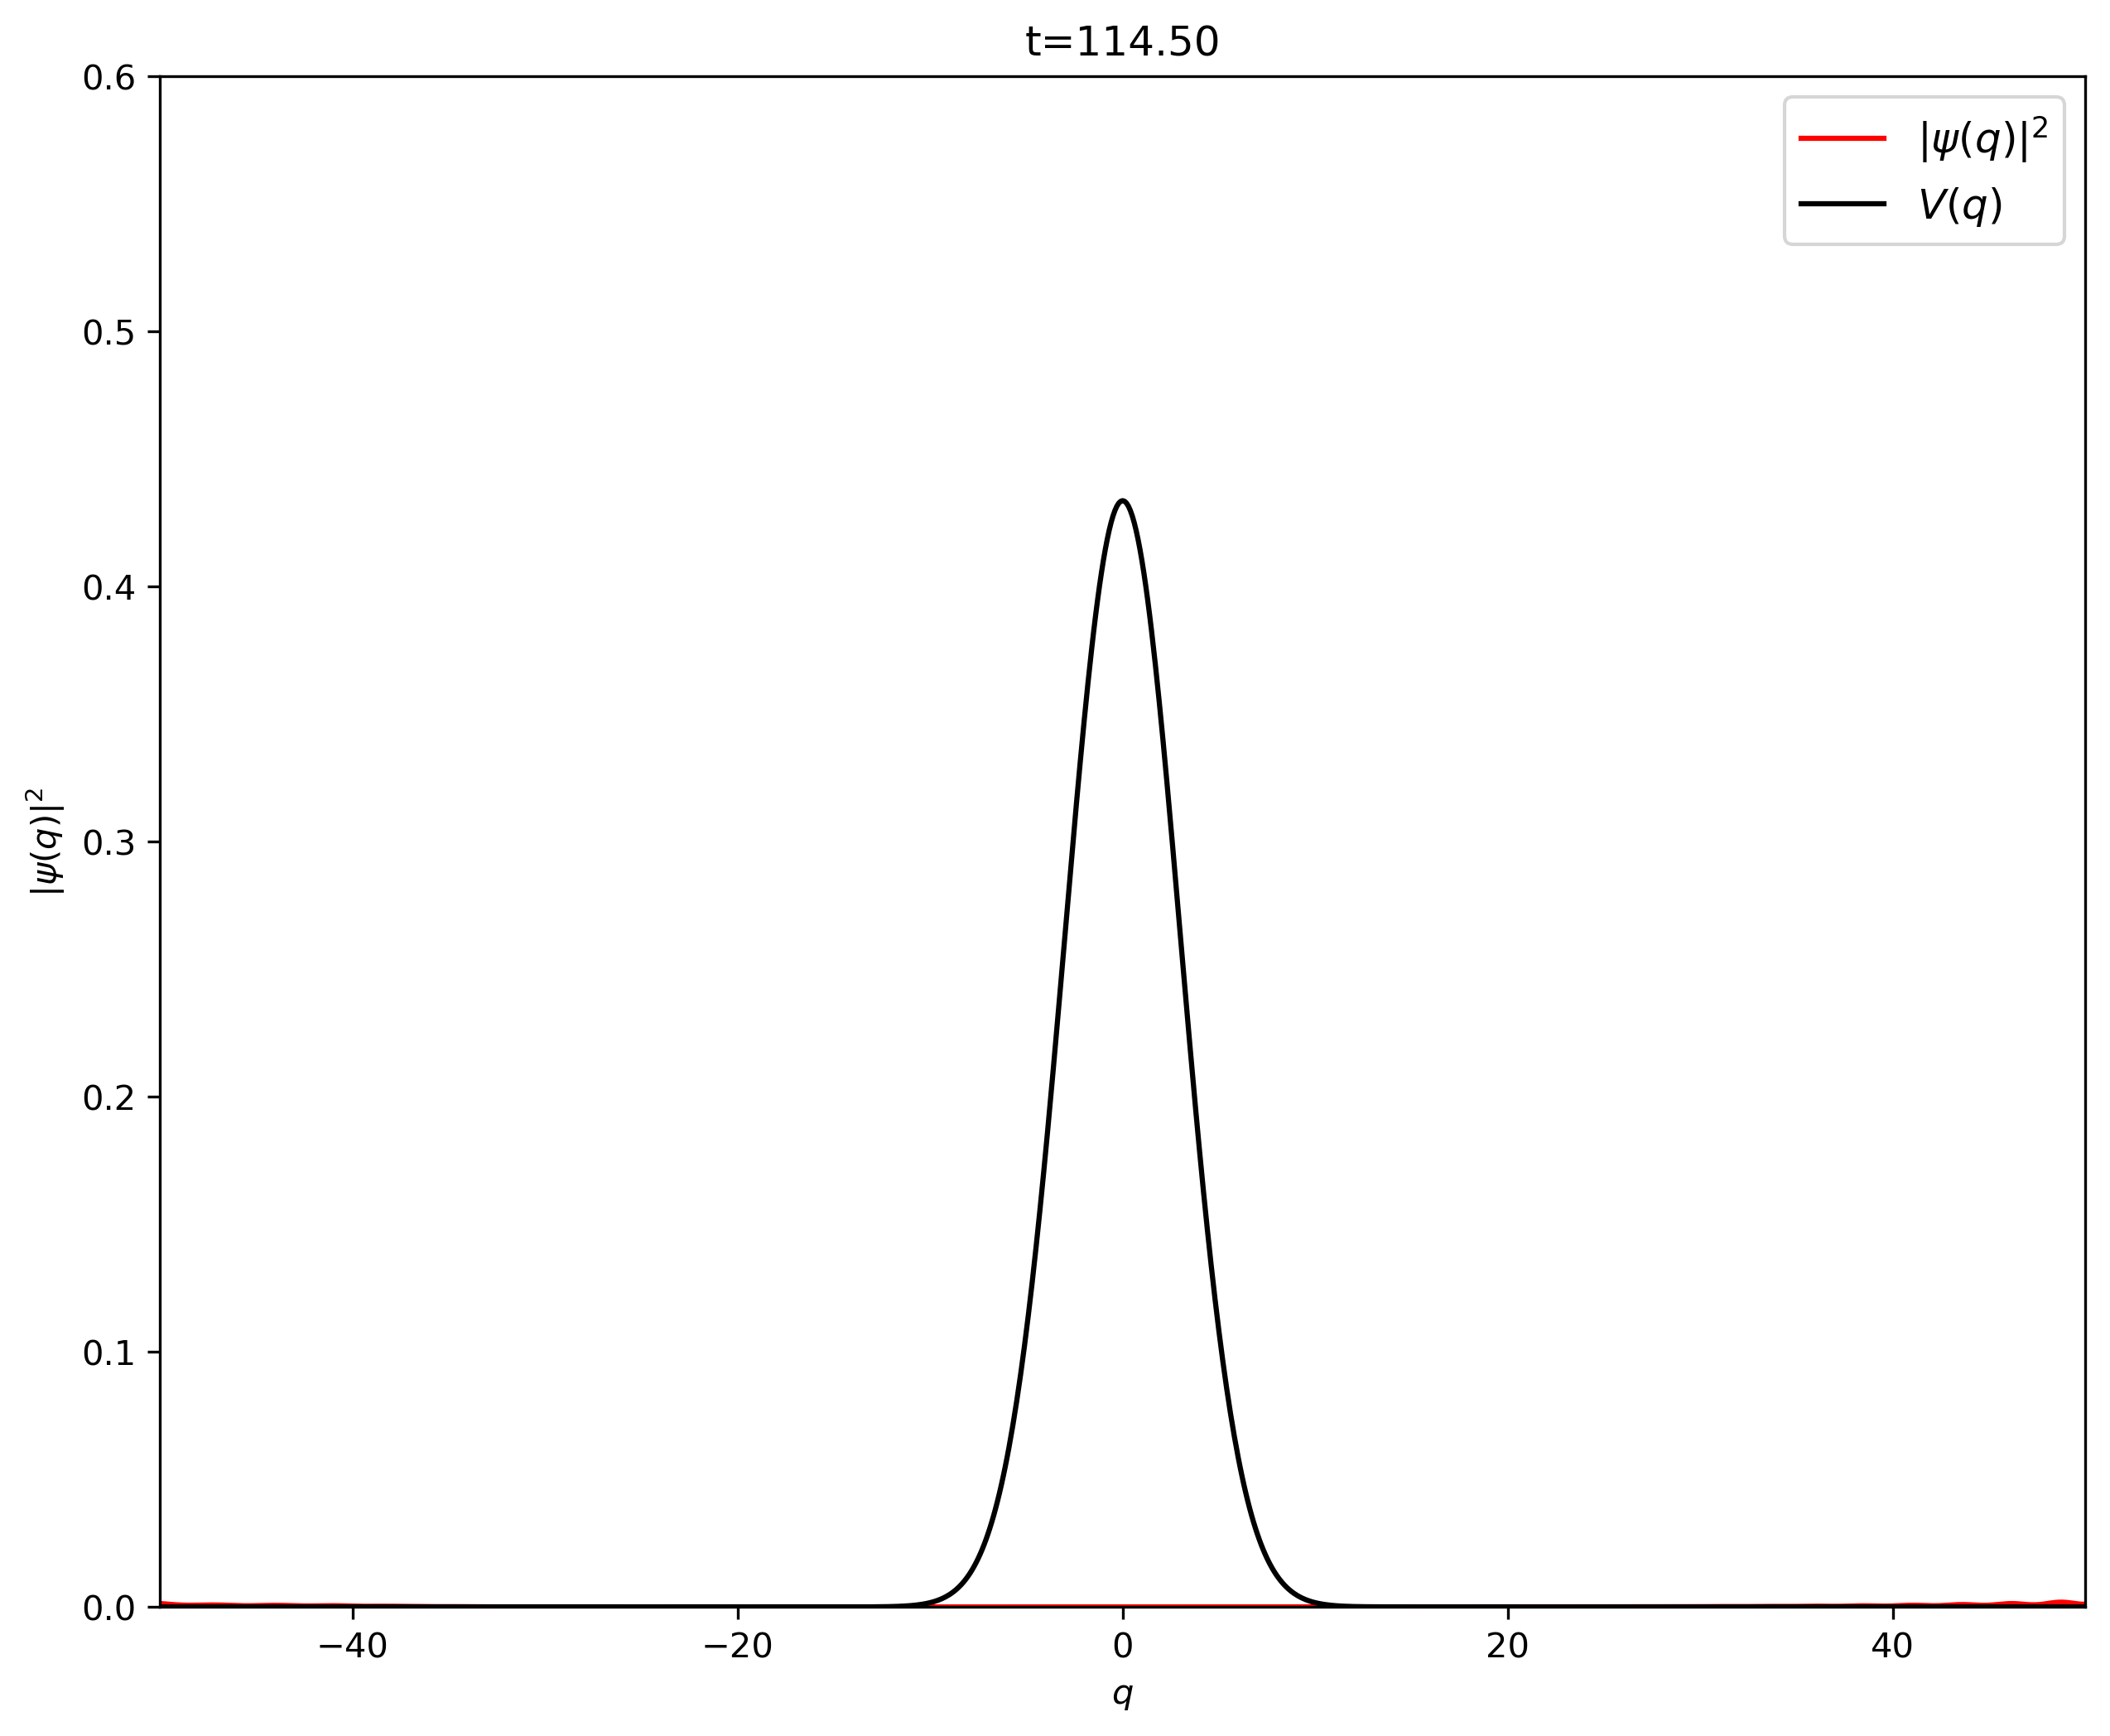

In [155]:
S = Schrodinger(x=x, psi_x0=psi_x0, V_x=V_x, hbar=hbar, m=m, k0=-28)
#creating the schrodinger object

xlim = (-50, 50)
ylim = (0,0.6)
save_wave(xlim=xlim, ylim=ylim, S=S, frames=frames, dt=dt, N_steps=N_steps, name='single_barrier_above', save=True)